In [5]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

def construct_kernels_centralnode(fileinput,els,kernels_s,kernels_n,traction_kernels_s,traction_kernels_n, matrix_slip):
    
    bctype_x = fileinput["bc_type_x"].values
    bctype_y = fileinput["bc_type_y"].values
    labels = fileinput["collection"].values
    
    n_els = len(els.x1)
    Nunknowns = 6 * n_els

    # Linear operator for central node BCs
    kerneleval_x = np.zeros((n_els, Nunknowns))
    kerneleval_y = np.zeros((n_els, Nunknowns))

    # x,y-kernels
    for i in np.unique(labels):
        index = np.where(labels == i)[0]
        for j in index:
            if bctype_x[j] == "u_global":
                for k in range(0, 3):
                    kerneleval_x[j, k::6] = kernels_s[3][j, k::3]
                    kerneleval_x[j, k + 3 :: 6] = kernels_n[3][j, k::3]
            elif bctype_x[j] == "t_local":
                for k in range(0, 3):
                    kerneleval_x[j, k::6] = traction_kernels_s[0][j, k::3]
                    kerneleval_x[j, k + 3 :: 6] = traction_kernels_n[0][j, k::3]
            elif bctype_x[j] == "s_local":
                kerneleval_x[j, :] = matrix_slip[2::6, :][j, :]
            else:
                raise ValueError("unrecognized boundary condition type")

            if bctype_y[j] == "u_global":
                for k in range(0, 3):
                    kerneleval_y[j, k::6] = kernels_s[4][j, k::3]
                    kerneleval_y[j, k + 3 :: 6] = kernels_n[4][j, k::3]
            elif bctype_y[j] == "t_local":
                for k in range(0, 3):
                    kerneleval_y[j, k::6] = traction_kernels_s[1][j, k::3]
                    kerneleval_y[j, k + 3 :: 6] = traction_kernels_n[1][j, k::3]
            elif bctype_y[j] == "s_local":
                kerneleval_y[j, :] = matrix_slip[3::6, :][j, :]
            else:
                raise ValueError("unrecognized boundary condition type")
            
    return kerneleval_x,kerneleval_y

def extract_quadratic_components(quadratic_coefs,n_els):
    # extract (s,n) components and store them in 2 separate vectors
    quadratic_coefs_s = np.zeros((3 * n_els, 1))
    quadratic_coefs_n = np.zeros((3 * n_els, 1))
    for i in range(n_els):
        quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
        quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]
    
    return quadratic_coefs_s,quadratic_coefs_n

def discretize_els(els,n):
    n_els = len(els.x1)
    x_obs = np.zeros((n_els*n,1))
    y_obs = np.zeros( (n_els*n,1))

    return x_obs, y_obs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['left_topo' 'mbt' 'ramp_mft' 'right_edge' 'right_topo' 'topo']


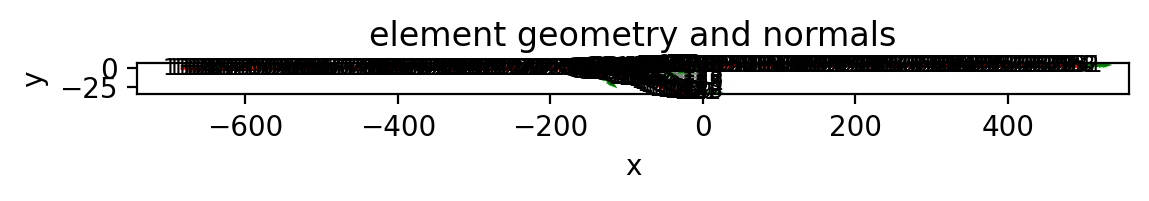

In [6]:
# Elastic parameters
mu = 1
nu = 0.25

# read fault geometry file
fileinput = pd.read_csv("mht_geometry_locked_5_km.csv")

# print(fileinput.head())
x1 = fileinput["x1"].values
x2 = fileinput["x2"].values
y1 = fileinput["y1"].values
y2 = fileinput["y2"].values
bc_x = fileinput["bc_x"].values
bc_y = fileinput["bc_y"].values
bctype_x = fileinput["bc_type_x"].values
bctype_y = fileinput["bc_type_y"].values

labels = fileinput["collection"].values
print(np.unique(labels))

# create bemcs data structure
els = bemcs.initialize_els()
els.x1 = x1
els.y1 = y1
els.x2 = x2
els.y2 = y2
bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

In [7]:
index_open, index_overlap, index_triple = bemcs.label_nodes(els)
N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_open)  # open node equations
N_i = 4 * len(index_overlap)  # overlapping node equations
N_t = 6 * len(index_triple)  # triple junction equations

Nequations = N_c + N_o + N_i + N_t
Nunknowns = 6 * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# apply BCs at central nodes
BC_c[0::2, 0] = bc_x
BC_c[1::2, 0] = bc_y

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

# Design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(
    els, reference="local"
)

# Patch center locations
# (need to be shifted an infinitesimal amount in unit normal direction for displacement bcs)
epsilonr = 1e-6 * (bctype_x == "u_global").astype(float)
obs_xy = np.vstack((els.x_centers, els.y_centers)).T
x_obs = (obs_xy[:, 0] + epsilonr * els.x_normals).reshape(-1, 1)
y_obs = (obs_xy[:, 1] + epsilonr * els.y_normals).reshape(-1, 1)

# Compute shear and tensile stress kernels evaluated ONLY at the center of each element
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Convert to traction kernels [Nobs x Ncoefficients]
traction_kernels_s = bemcs.get_traction_kernels(els, kernels_s, flag="local")
traction_kernels_n = bemcs.get_traction_kernels(els, kernels_n, flag="local")

Number of open nodes = 2
: [array([393]), array([695])]
Number of 2-overlap nodes = 324
: [array([ 396, -395]), array([ 399, -398]), array([ 402, -401]), array([ 405, -404]), array([ 408, -407]), array([ 411, -410]), array([ 414, -413]), array([ 417, -416]), array([ 420, -419]), array([ 423, -422]), array([ 426, -425]), array([ 429, -428]), array([ 432, -431]), array([ 435, -434]), array([ 438, -437]), array([ 441, -440]), array([ 444, -443]), array([ 447, -446]), array([ 450, -449]), array([ 453, -452]), array([ 456, -455]), array([ 459, -458]), array([ 462, -461]), array([ 465, -464]), array([ 468, -467]), array([ 471, -470]), array([ 474, -473]), array([ 477, -476]), array([ 480, -479]), array([ 483, -482]), array([ 486, -485]), array([ 489, -488]), array([ 492, -491]), array([ 495, -494]), array([ 498, -497]), array([ 501, -500]), array([ 504, -503]), array([ 507, -506]), array([ 510, -509]), array([ 513, -512]), array([ 516, -515]), array([ 519, -518]), array([ 522, -521]), array(

/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/bemcs/bemcs.py:149: RuntimeWarning: divide by zero encountered in divide
  arctan_x_minus_a = np.pi / 2 * np.sign(y / (a - x)) - np.arctan(y / (a - x))


## Interseismic case

In [8]:
# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))

matrix_system_o, matrix_system_i, matrix_system_t = bemcs.construct_smoothoperator(
    els, index_open, index_overlap, index_triple
)

kerneleval_x, kerneleval_y = construct_kernels_centralnode(
    fileinput,
    els,
    kernels_s,
    kernels_n,
    traction_kernels_s,
    traction_kernels_n,
    matrix_slip,
)

# populate matrix_system for central nodes
matrix_system_c[0::2, :] = kerneleval_x
matrix_system_c[1::2, :] = kerneleval_y

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs_locked = np.linalg.inv(matrix_system) @ BCvector
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))

Linear Operator Condition Number: 33843.26647774208


## Coseismic case

In [9]:
# provide new input file for locked system with appropriate BCs
fileinput = pd.read_csv("mht_geometry_gorkha_5_km.csv")
bc_x = fileinput["bc_x"].values
bc_y = fileinput["bc_y"].values
BC_c[0::2, 0] = bc_x
BC_c[1::2, 0] = bc_y

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))

kerneleval_x, kerneleval_y = construct_kernels_centralnode(
    fileinput,
    els,
    kernels_s,
    kernels_n,
    traction_kernels_s,
    traction_kernels_n,
    matrix_slip,
)

# populate matrix_system for central nodes
matrix_system_c[0::2, :] = kerneleval_x
matrix_system_c[1::2, :] = kerneleval_y

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs_coseismic = np.linalg.inv(matrix_system) @ BCvector
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))

Linear Operator Condition Number: 30600.925532251636


In [15]:
# els.keys()
len(els.x1)
# n_els

331